In [1]:
out = !pip install ipywidgets mido
out = !apt install -y timidity

%matplotlib inline
import numpy as np
from random import choice
import math
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange
import pickle
import mido
import IPython
from matplotlib import pyplot as plt
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

In [2]:
def downlaod(url):
    import requests as r
    from zipfile import ZipFile as zf
    from io import BytesIO

    res = r.get(url)
    data = zf(BytesIO(res.content))
    data.extractall('dataset')
    return res
# downlaod('https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip')
def parse():
    import pandas as pd

    path = './dataset/maestro-v3.0.0/'
    df = pd.read_csv(path + 'maestro-v3.0.0.csv')
    max_len_song = 0
    songs = []
    for song in tqdm(list(df[df.canonical_composer == 'Johann Sebastian Bach'].iloc)):
        notes = []
        file = path + song.midi_filename
        mid = mido.MidiFile(file, clip=True)
        for msg in mid.tracks[1]:
            if msg.type == 'note_on':
                notes.append([msg.note, msg.velocity, msg.time])
        notes = torch.tensor(notes, dtype=torch.float)
        songs.append(notes)
        if notes.size(0) > max_len_song:
            max_len_song = notes.size(0)

    pad = lambda ten: nn.functional.pad(ten, (0, 0, 0, max_len_song - ten.size(0)))
    tensor_songs = [pad(song) for song in songs]

    with open('./dataset/songs.dump', 'wb') as f:
        pickle.dump(tensor_songs, f)
    return tensor_songs

try:
    with open('./dataset/songs.dump', 'rb') as f:
        songs = pickle.load(f)
except FileNotFoundError:
    songs = parse()
    
def song_to_mid(song):
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    for note in song:
        note, vel, time = note
        msg = mido.Message('note_on', note=int(note), velocity=int(vel), time=int(time))
        track.append(msg)
    mid.save('./dataset/test.mid')

def midi_to_wav():
    stdout = !timidity ./dataset/test.mid -Ow -o ./dataset/out.wav
    error = 'No such' in '\n'.join(stdout)
    if error:
        raise Exception('No midi file')

def play():
    return IPython.display.Audio('./dataset/out.wav')

def play_song(song):
    song_to_mid(song)
    midi_to_wav()
    return play()

def rand_note():
    song = choice(songs)
    note = song[np.random.randint(song.size(0))]
    while (note == torch.zeros(3)).any():
        note = song[np.random.randint(song.size(0))]
    return note

In [3]:
dtld = DataLoader(songs, batch_size=4, shuffle=True)
song = next(iter(dtld))[0]
song.dtype

torch.float32

In [4]:
class LSTM_cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_cell, self).__init__()
        self.input_size = input_size
        self.hs = hidden_size

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        def get_tensor(dim):
            stdv = 1. / math.sqrt(dim[1])
            return torch.randn(dim, device=dev,
                               dtype=torch.float).uniform_(-stdv, stdv)
            
        self.W = nn.Parameter(get_tensor((input_size, hidden_size * 4)))
        self.U = nn.Parameter(get_tensor((hidden_size, hidden_size * 4)))
        self.b = nn.Parameter(get_tensor((1, hidden_size * 4)))
        
    def forward(self, x, hc):
        BS = x.shape[0]
        x = x.reshape(BS, 1, -1)
        HS = self.hs
        h, c = hc.reshape(2, BS, 1, -1)
        W = torch.stack([self.W]*BS).to(dev)
        U = torch.stack([self.U]*BS).to(dev)
        b = torch.stack([self.b]*BS).to(dev)
        gates = x.bmm(W) + h.bmm(U) + b
        f, i, o, c_ = (
            self.sig(gates[:,:, :HS]),
            self.sig(gates[:,:, HS : 2*HS]),
            self.sig(gates[:,:, 2*HS : 3*HS]),
            self.tanh(gates[:,:, 3*HS : ])
        )
        c = f * c + i * c_
        h = o * self.tanh(c)
        hc = torch.stack([h,c])
        return o.squeeze(dim=1), hc

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.cell = nn.LSTMCell(input_size, hidden_size)
        self.l1 = nn.Sequential( nn.Linear(hidden_size, 3), nn.ReLU() )
        self.hs = hidden_size
        self.input_size = input_size

    def forward(self, x):
        BS = x.shape[0]
        ot, ct = torch.randn(BS, self.hs, device=dev), torch.randn(BS, self.hs, device=dev)
        seq_len = x.shape[1]
        o = []
        for t in range(seq_len):
            xt = x[:,t,:]
            ot, ct = self.cell(xt, (ot, ct))
            out = self.l1(ot)
            o.append(out)
        return torch.stack(o).movedim((0, 1, 2), (1, 0, 2)) # put BS at start
    
    def gen_song(self, x0, length):
        # hc = tuple(torch.randn(2, 1, self.hs, device=dev))
        ot, ct = torch.randn(1, self.hs, device=dev), torch.randn(1, self.hs, device=dev)
        o = []
        xt = x0.unsqueeze(0).to(dev)
        for t in range(length):
            ot, ct = self.cell(xt, (ot, ct))
            out = self.l1(ot)
            xt = out
            o.append(out)
        return torch.stack(o).movedim((0, 1, 2), (1, 0, 2)).squeeze() # put BS at start
    
    def save_checkpoint(self, path, epoch=-1, losses=[]):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'losses': losses,
        }, path)
        
    def load_checkpoint(self, path):
        checkpnt = torch.load(path)
        self.load_state_dict(checkpnt['model_state_dict'])
        return checkpnt['losses'], checkpnt['epoch']

model = LSTM(IS := 3, HS := 1024).to(dev)
# model(song.reshape(1, -1, 3).to(dev)).shape
model(torch.randn((15, 123, IS), device=dev)).shape
try:
    losses, init_epoch = model.load_checkpoint('./checkpnts/current.pt')
except (FileNotFoundError, RuntimeError):
    losses = []
    init_epoch = -1

In [ ]:
epochs = 100
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in (t := trange(init_epoch + 1, epochs)):
    for i, x in enumerate(tqdm(dtld, leave=False)):
        x = x.to(dev)
        x_hat = model(x)
        loss = loss_fn(x, x_hat)

        for p in model.parameters():
            p.grad = None
        loss.backward()
        optim.step()
        loss = loss.item()
        losses.append(loss)
        t.set_description('Losss = %.4f' % loss)

        plt.clf()
        plt.plot(losses, label='Losses')
        plt.savefig(f'./images/plot_{i}_{epoch}')
        try:
            epoch_song = model.gen_song(rand_note(), 100)
            song_to_mid(epoch_song)
            midi_to_wav()
        except Exception:
            pass
        model.save_checkpoint('./checkpnts/current.pt', epoch=epoch, losses=losses)
    model.save_checkpoint(f'./checkpnts/epoch_{epoch}.pt', epoch=epoch, losses=losses)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

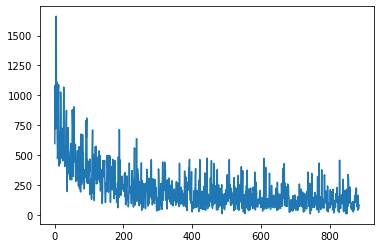

In [15]:
epoch_song = model.gen_song(rand_note(), 100)
song_to_mid(epoch_song)
midi_to_wav()

plt.plot(losses, label='Losses')
plt.show()
play()